In [1]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 9)

from matplotlib import patches
from matplotlib import animation, rc
import matplotlib.lines as mlines

import ROOT
import fastjet as fj
import fjext
import fjcontrib
import fjtools

import pythia8
import pythiafjext
import pythiaext
from heppy.pythiautils import configuration as pyconf

from tqdm.notebook import tqdm
import argparse
import os
import sys

# standard numerical library imports
import numpy as np
rng = np.random.RandomState(0)

# matplotlib is required for this example
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 200em; }</style>"))


Welcome to JupyROOT 6.22/08


In [2]:
def get_args_from_settings(ssettings):
    sys.argv=[' '] + ssettings.split()
    parser = argparse.ArgumentParser(description='pythia8 fastjet on the fly')
    pyconf.add_standard_pythia_args(parser)
    parser.add_argument('--output', default="test_ang_ue.root", type=str)
    parser.add_argument('--user-seed', help='pythia seed', default=1111, type=int)
    args = parser.parse_args()
    return args

In [3]:
mycfg = []
ssettings = "--py-ecm 5000 --user-seed=100000 --nev 1000"
args = get_args_from_settings(ssettings)
pythia_hard = pyconf.create_and_init_pythia_from_args(args, mycfg)

['HardQCD:all=on', 'PhaseSpace:bias2Selection=on', 'PhaseSpace:bias2SelectionPow=4', 'PhaseSpace:bias2SelectionRef=10', 'Beams:eCM = 5000.0']
[i] strings read to PYTHIA  [['HardQCD:all=on', 'PhaseSpace:bias2Selection=on', 'PhaseSpace:bias2SelectionPow=4', 'PhaseSpace:bias2SelectionRef=10', 'Beams:eCM = 5000.0', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on']]
[i] pythia initialized with ['HardQCD:all=on', 'PhaseSpace:bias2Selection=on', 'PhaseSpace:bias2SelectionPow=4', 'PhaseSpace:bias2SelectionRef=10', 'Beams:eCM = 5000.0', 'Next:numberCount = 0', 'Next:numberShowEvent = 0', 'Next:numberShowInfo = 0', 'Next:numberShowProcess = 0', 'Stat:showProcessLevel = on']

 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------

In [4]:
max_eta_hadron=2
parts_selector_h = fj.SelectorAbsEtaMax(max_eta_hadron)
jet_R0 = 0.4
jet_selector = fj.SelectorPtMin(100.0) & fj.SelectorPtMax(105.0) & fj.SelectorAbsEtaMax(max_eta_hadron - 1.05 * jet_R0)

In [5]:
# print the banner first
fj.ClusterSequence.print_banner()
print()
# set up our jet definition and a jet selector
jet_R0 = 0.4
jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R0)
print(jet_def)

sj_rs = [0.1, 0.2, 0.3]
sj_defs = []
for r in sj_rs:
    _sj_def = fj.JetDefinition(fj.antikt_algorithm, 0.1)
    print(_sj_def)
    sj_defs.append(_sj_def)



Longitudinally invariant anti-kt algorithm with R = 0.4 and E scheme recombination
Longitudinally invariant anti-kt algorithm with R = 0.1 and E scheme recombination
Longitudinally invariant anti-kt algorithm with R = 0.1 and E scheme recombination
Longitudinally invariant anti-kt algorithm with R = 0.1 and E scheme recombination
#--------------------------------------------------------------------------
#                         FastJet release 3.3.3
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without wa

In [6]:
def print_jet_constits(j):
    print('[jet]', j.perp(), j.phi(), j.eta(), ':', [_c.user_index() for _c in j.constituents()])

In [7]:
# for n in tqdm(range(args.nev)):
def next_event():
    subjets = []
    while (1):
        if not pythia_hard.next():
            continue
        parts_pythia_h = pythiafjext.vectorize_select(pythia_hard, [pythiafjext.kFinal], 0, False)
        parts_pythia_h_selected = parts_selector_h(parts_pythia_h)
        mult_hard = len(parts_pythia_h_selected)
        jets_h = fj.sorted_by_pt(jet_selector(jet_def(parts_pythia_h_selected)))
        if len(jets_h) < 1:
            continue
        j = jets_h[0]

        #make the subjets
        subjets.clear()
        _accept_flag = True
        for sj_def in sj_defs:
            _sjets = fj.sorted_by_pt(sj_def(j.constituents()))
            subjets.append(_sjets)
            if len(_sjets) < 3:
                _accept_flag = False
        if _accept_flag is False:
            continue

        return j, subjets

In [8]:
#j, jbg, jbgsub = next_event()
#print_jet_constits(j)
#print_jet_constits(jbg)
#print_jet_constits(jbgsub)

In [9]:
def draw_jet(j):
    # for the jet but not subjets
    pts = [p.perp() for p in fj.sorted_by_pt(j.constituents())]
    ys = [j.rapidity() - p.rapidity() for p in fj.sorted_by_pt(j.constituents())]
    phis = [j.delta_phi_to(p) for p in fj.sorted_by_pt(j.constituents())]
    
    phis.append(jet_R0)
    phis.append(-jet_R0)
    ys.append(jet_R0)
    ys.append(-jet_R0)
    pts.append(0)
    pts.append(0)
    zs = [pt/j.perp() for pt in pts]
    zs_sized = [z*1000. for z in zs]
    cs = [int(z*100.) for z in zs]

    plt.figure()
    # plt.scatter(phis, ys, c=colors, s=zs_sized, alpha=0.4, cmap="PuOr") #cmap='viridis')
    plt.scatter(phis, ys, c=cs, s=zs_sized, alpha=0.4, cmap="magma") #cmap='viridis')
    
    plt.xlabel('phi')
    plt.ylabel('y')
    plt.colorbar();  # show color scale
    plt.show()
    #plt.rcdefaults()

In [33]:
import importlib
import subjets_geometry as sjgeom
importlib.reload(sjgeom)


<module 'subjets_geometry' from '/Users/ploskon/devel/pyjetty/pyjetty/sandbox/forINT21-2b/subjets_geometry.py'>

In [34]:
def draw_subjets(j, scale_pt=0, sj_r = 0.1):
    sj_def = fj.JetDefinition(fj.antikt_algorithm, sj_r)
    sjs = fj.sorted_by_pt(sj_def(j.constituents()))
    # for subjets
    pts = []
    ys = []
    phis = []
    cs = []
    lines = []
    circles = []
    for i,sj in enumerate(sjs):
        sc = fj.sorted_by_pt(sj.constituents())
        pts.extend([p.perp() for p in sc])
        ys.extend([j.rapidity() - p.rapidity() for p in sc])
        phis.extend([j.delta_phi_to(p) for p in sc])
        if i == 0:
            _col = [1, 0, 0, 0.3]
            for p in sc:
                cs.append(_col)
                part_dphi = j.delta_phi_to(p)
                part_deta = j.rapidity() - p.rapidity()
                sj_dphi = j.delta_phi_to(sj)
                sj_deta = j.rapidity() - sj.rapidity()
                lines.append([sj_dphi, part_dphi,
                             sj_deta, part_deta,
                             cs[-1]])
            circles.append([sj_dphi, sj_deta, sj_r, _col])
            continue
        if i == 1:
            _col = [0.1, .75, 0.1, 0.3]
            for p in sc:
                cs.append(_col)
                part_dphi = j.delta_phi_to(p)
                part_deta = j.rapidity() - p.rapidity()
                sj_dphi = j.delta_phi_to(sj)
                sj_deta = j.rapidity() - sj.rapidity()
                lines.append([sj_dphi, part_dphi,
                             sj_deta, part_deta,
                             cs[-1]])
            circles.append([sj_dphi, sj_deta, sj_r, _col])
            continue
        if i == 2:
            _col = [0, 0, 1, 0.3]
            for p in sc:
                cs.append(_col)
                part_dphi = j.delta_phi_to(p)
                part_deta = j.rapidity() - p.rapidity()
                sj_dphi = j.delta_phi_to(sj)
                sj_deta = j.rapidity() - sj.rapidity()
                lines.append([sj_dphi, part_dphi,
                             sj_deta, part_deta,
                             cs[-1]])
            circles.append([sj_dphi, sj_deta, sj_r, _col])
            continue
        if i > 2:
            gr_scale = (len(sjs) - i - 2)/len(sjs)
            # gr_col = 1.0 - 0.3 * gr_scale
            gr_col = 1.0 - (0.1 * (i - 2))
            if gr_col <= 0.1:
                gr_col = 0.1
            gr_col = 1.0 - gr_col
            print(gr_col)
            _col = [gr_col, gr_col, gr_col, 0.3]
            for p in sc:
                cs.append(_col)
                part_dphi = j.delta_phi_to(p)
                part_deta = j.rapidity() - p.rapidity()
                sj_dphi = j.delta_phi_to(sj)
                sj_deta = j.rapidity() - sj.rapidity()
                lines.append([sj_dphi, part_dphi,
                             sj_deta, part_deta,
                             cs[-1]])
            circles.append([sj_dphi, sj_deta, sj_r, _col])

    phis.append(jet_R0)
    phis.append(-jet_R0)
    ys.append(jet_R0)
    ys.append(-jet_R0)
    pts.append(0)
    pts.append(0)
    if scale_pt == 0:
        scale_pt = j.perp()
    zs = [pt/scale_pt for pt in pts]
    zs_sized = [z*1000. for z in zs]
    cs.append([0,0,0,0])
    cs.append([0,0,0,0])

    fig = plt.figure()
    # plt.scatter(phis, ys, c=colors, s=zs_sized, alpha=0.4, cmap="PuOr") #cmap='viridis')
    # plt.scatter(phis, ys, c=cs, s=zs_sized, alpha=0.4, cmap="magma") #cmap='viridis')
    plt.scatter(phis, ys, c=cs, s=zs_sized, alpha=0.4, cmap="magma") #cmap='viridis')
    
    plt.xlabel(r"$\Delta\varphi$")
    plt.ylabel(r"$\Delta y$")

    ax = fig.axes[0]
    # transform = ax.transAxes
    transform = ax.transData

    # plt.colorbar();  # show color scale    
    for l in lines:
        # _line = mlines.Line2D([l[0], l[1]], [l[2], l[3]], color='red')
        _line = mlines.Line2D([l[0], l[1]], [l[2], l[3]], color=l[4])
        # _line = mlines.Line2D([0, phis[i]], [0, ys[i]], color='red')
        # _line = mlines.Line2D([0, 1], [0.4, -0.4], color='red')
        _line.set_transform(transform)
        ax.add_line(_line)
    # fig.add_artist(line)
    
    c_patches = []
    for ic, c in enumerate(circles):
        _pc = sjgeom.SubjetPatch([c[0], c[1]], sj_r, 0.4)
        c_patches.append(_pc)

    for ic, pc in enumerate(c_patches):
        for pcx in c_patches[:ic]:
            #pc.resolve_overlap_with_subjet_patch(pcx)
            #pc.resolve_overlap_with_sj(pcx)
            pc.clip_to_sj(pcx)

    for ic, _pc in enumerate(c_patches):
        _pc.plot_patch_ax(ax, circles[ic][3], 0)

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylim(-0.4, 0.4)

    plt.show()
    print(j.perp(), sjs[0].perp(), sjs[0].perp()/j.perp())
    # plt.rcdefaults()


0.09999999999999998
0.19999999999999996
0.30000000000000004
0.4
0.5
0.6000000000000001


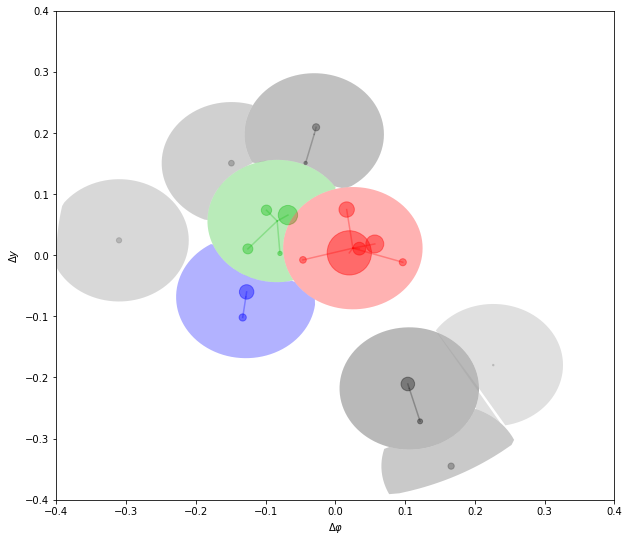

100.04132603053411 69.44426885975899 0.6941558215508216


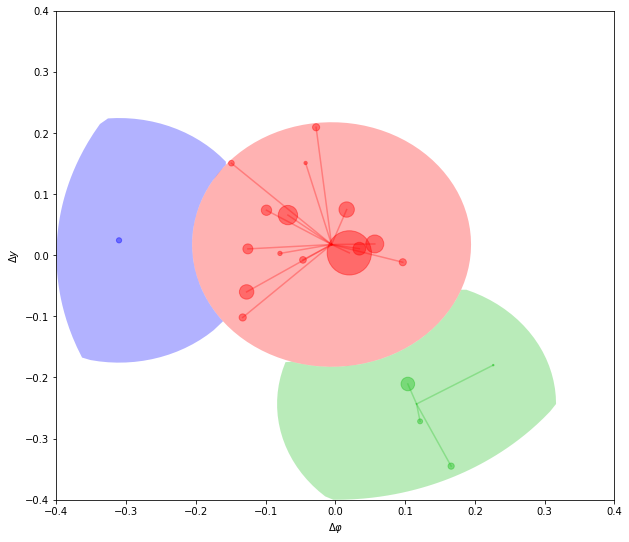

100.04132603053411 93.16659608810343 0.9312810993695505


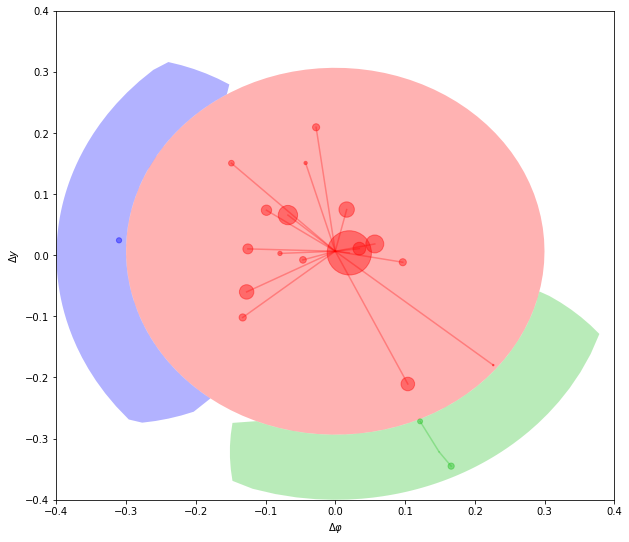

100.04132603053411 97.81841936538312 0.9777801159445595
0.09999999999999998
0.19999999999999996
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8


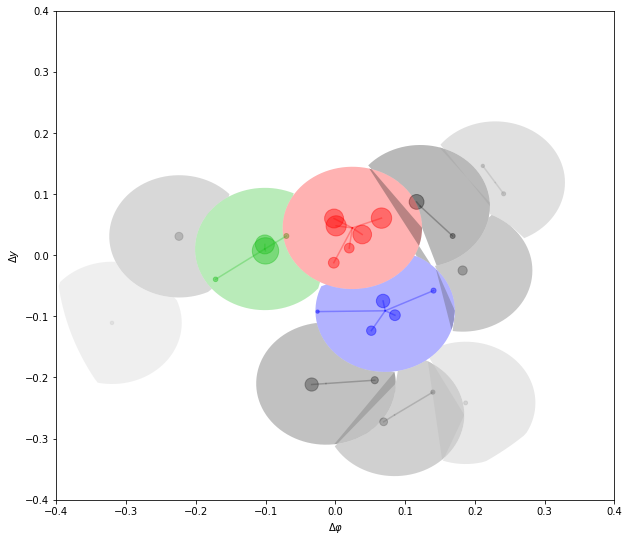

101.97488485048834 44.37970163069885 0.4352022725572739
0.09999999999999998


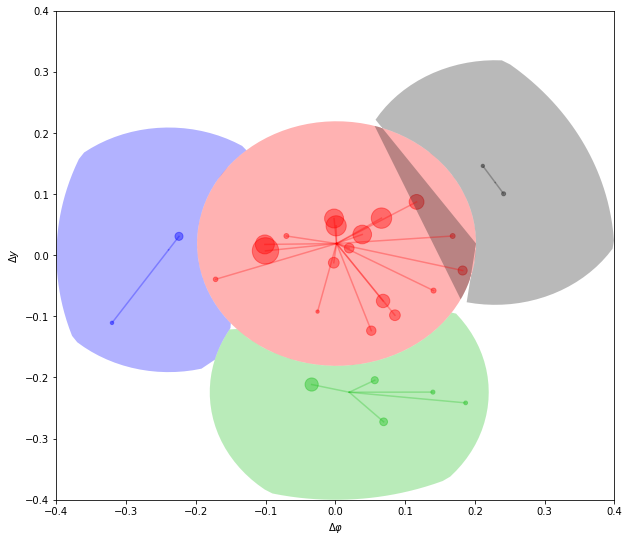

101.97488485048834 91.29985618597242 0.8953170804736162


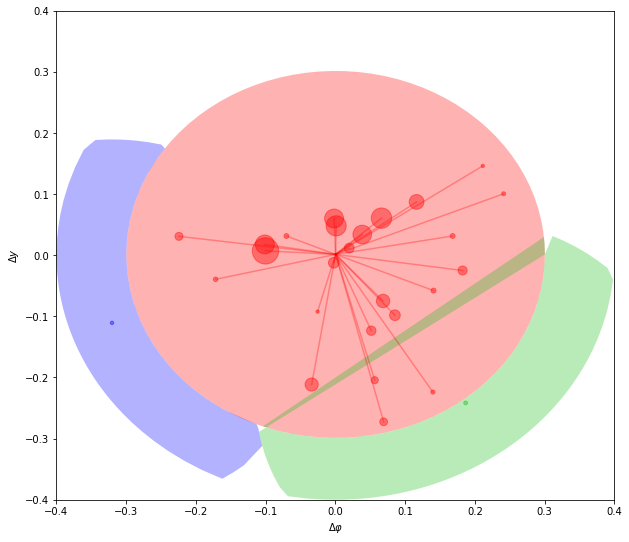

101.97488485048834 101.3173242063459 0.9935517392826035
0.09999999999999998
0.19999999999999996
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9


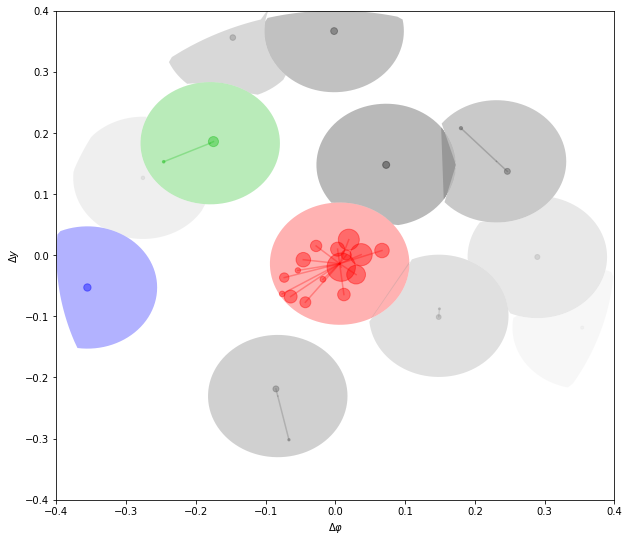

103.85900861102134 92.40692166028296 0.8897342935976851
0.09999999999999998
0.19999999999999996
0.30000000000000004
0.4


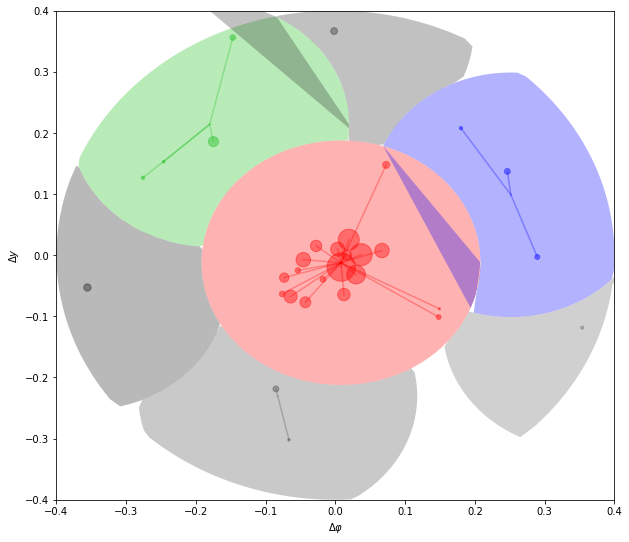

103.85900861102134 94.3733671693441 0.9086680917858229
0.09999999999999998
0.19999999999999996


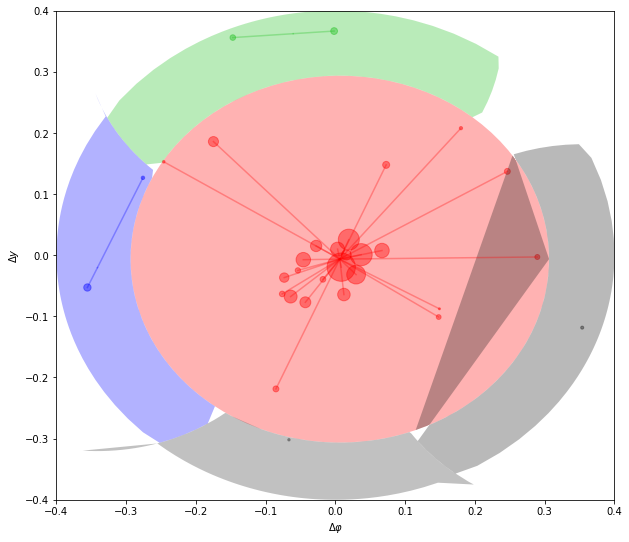

103.85900861102134 99.84429108557552 0.9613445421910201
0.09999999999999998
0.19999999999999996
0.30000000000000004
0.4
0.5


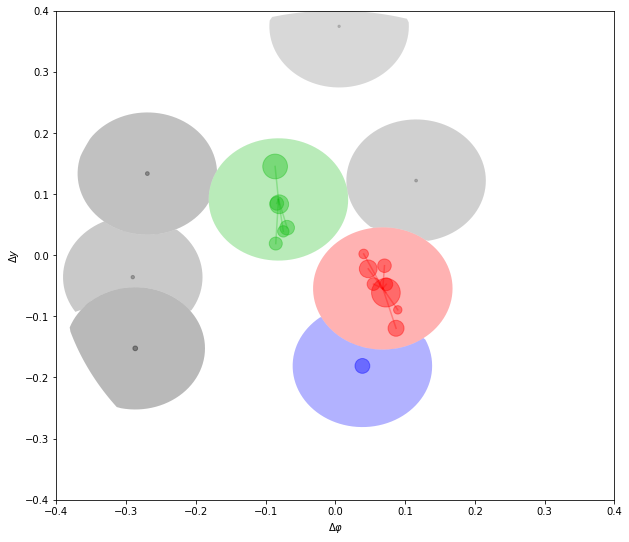

104.77407341625653 54.110661669603445 0.5164508728664905
0.09999999999999998


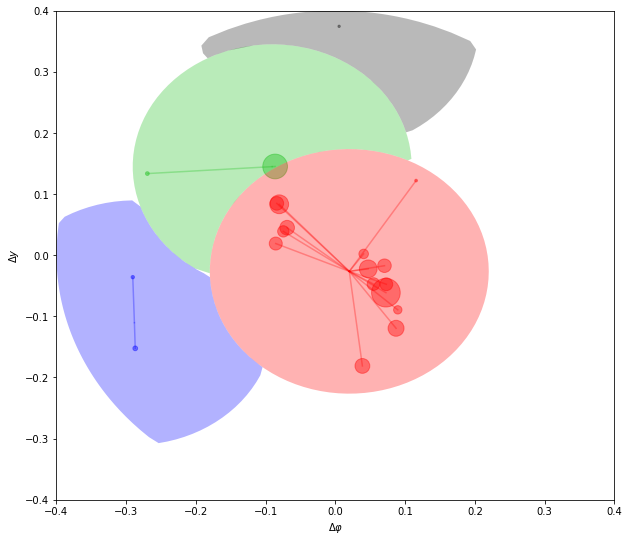

104.77407341625653 87.4904826405709 0.8350394309189477


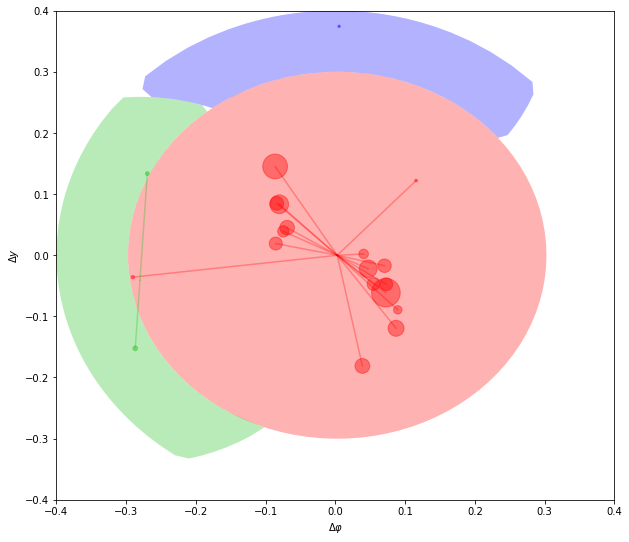

104.77407341625653 103.70163761923854 0.9897643017776229
0.09999999999999998
0.19999999999999996
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8


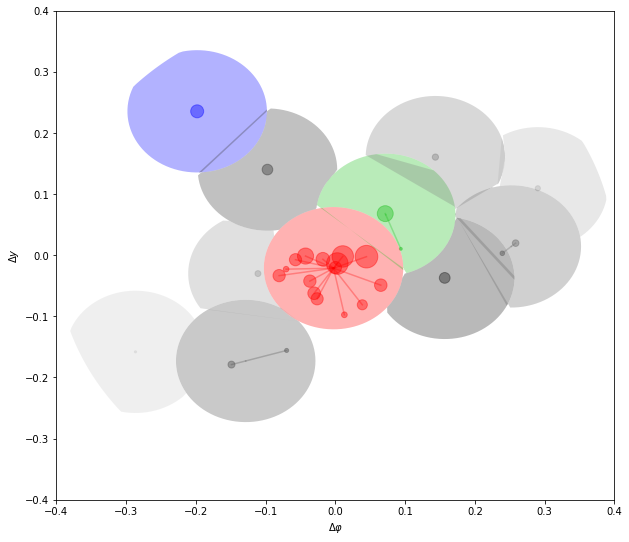

102.7821855275492 80.04192345549816 0.7787528845068599
0.09999999999999998


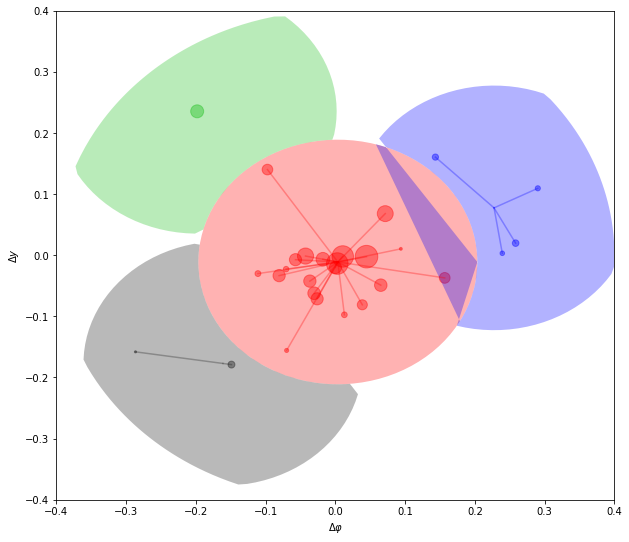

102.7821855275492 93.93429067090517 0.9139160661817948
0.09999999999999998


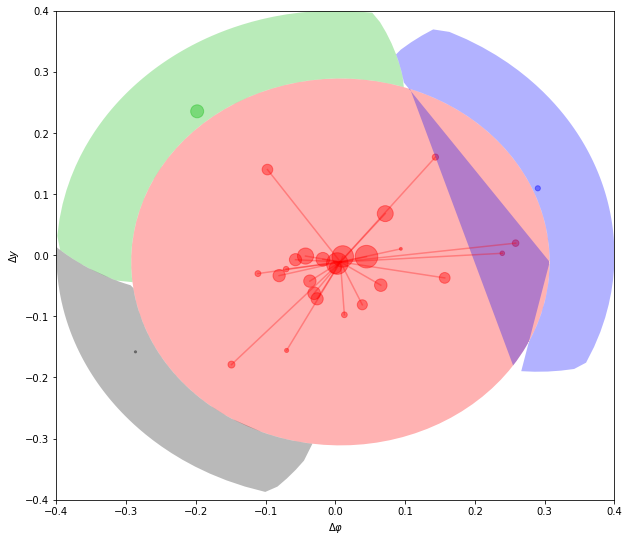

102.7821855275492 97.75215276826887 0.9510612395186702
 PYTHIA Warning in SimpleSpaceShower::pT2nextQCD: weight above unity  


In [35]:
save_jets = []
for n in range(5):
    j, subjets = next_event()
    save_jets.append(j)
    # draw_jet(j)
    for sj_r in sj_rs:
        draw_subjets(j, j.perp()/4., sj_r)


In [ ]:
pythia_hard.stat()

# voronoi diagrams
- consider adding the same but with the voronoi diagram marking (stop at R=jet_R0)

In [ ]:
with open('nice_jets', 'w') as f:
	for j in save_jets:
		print (j, file=f)
		for c in fj.sorted_by_pt(j.constituents()):
			print(' ', c, file=f)


In [ ]:
!ls